In [98]:
import urllib2
import pandas as pd
import re
import matplotlib
import json
from bs4 import BeautifulSoup as Soup
from snownlp import SnowNLP
import time
from pymongo import MongoClient
pd.options.display.max_colwidth = 100
import numpy as np

In [2]:
# response = urllib2.urlopen('https://bbs.ngacn.cc/thread.php?fid=-7&page=1&lite=xml')
# soup = Soup(response, 'lxml-xml')

# Connect to MongoDB

In [3]:
client = MongoClient('10.65.26.66', 27017, username='superhktds',password='[]',authSource='admin',authMechanism='SCRAM-SHA-1')
db_name = 'nga_2018'
db = client[db_name]
collection_useraction = db['useraction']

In [4]:
curser = db.nga_2018.find({})

In [5]:
df = pd.DataFrame(list(curser))

# 抓取8k+帖子， 100k+回复

In [6]:
opener = urllib2.build_opener()
opener.addheaders.append(('Cookie', '__utma=240585808.1647950274.1493176825.1501557294.1501563204.128; UM_distinctid=15f5197dfcb74d-03e107c3e4155-3a3e5e06-1fa400-15f5197dfccb86; CNZZDATA1264400273=581996257-1512720390-https%253A%252F%252Fweb.wechat.com%252F%7C1512720390; CNZZDATA1256638924=386043101-1493358985-https%253A%252F%252Fbbs.ngacn.cc%252F%7C1513557619; CNZZDATA1256638919=1774706182-1503030389-https%253A%252F%252Fbbs.ngacn.cc%252F%7C1515374600; CNZZDATA1256638935=856131897-1495096681-https%253A%252F%252Fbbs.ngacn.cc%252F%7C1517300476; bbsmisccookies=%7B%7D; taihe=9fb395a5f86a7bd1b896ed9a444ac540; ngacn0comUserInfo=wllfox%09wllfox%0939%0939%09%0914%0977664%094%090%09347%2C341%2C262%2C214%2C207%2C75%093_45%2C4_15%2C16_15%2C31_4%2C22_1280%2C12_30%2C77_75%2C61_2%2C91_30; CNZZDATA1256638943=29216387-1493343407-https%253A%252F%252Fbbs.ngacn.cc%252F%7C1520576491; CNZZDATA1262314555=226700705-1514443872-https%253A%252F%252Fbbs.ngacn.cc%252F%7C1521182844; ngaPassportUid=17747039; ngaPassportUrlencodedUname=wllfox; ngaPassportCid=Z8dperkpfc8f6eklcko44gq5d6fk7tq8rrh0f024; CNZZDATA1256638851=962096524-1493178972-https%253A%252F%252Fbbs.ngacn.cc%252F%7C1523579711; CNZZDATA1256638828=1904417898-1493342971-https%253A%252F%252Fbbs.ngacn.cc%252F%7C1523610037; CNZZDATA1256638858=1643246750-1493344248-https%253A%252F%252Fbbs.ngacn.cc%252F%7C1523612967; Hm_lvt_5adc78329e14807f050ce131992ae69b=1523849824; ngacn0comUserInfoCheck=c56634639c5e6f6e684a45492860d932; ngacn0comInfoCheckTime=1523868472; CNZZDATA1256638820=1611885119-1493172925-https%253A%252F%252Fbbs.ngacn.cc%252F%7C1523865039; CNZZDATA30043604=cnzz_eid%3D1757245345-1493176111-null%26ntime%3D1523864396; CNZZDATA30039253=cnzz_eid%3D567575914-1493172144-null%26ntime%3D1523864677; lastvisit=1523868828; lastpath=/read.php?tid=13875294&_ff=-7; Hm_lpvt_5adc78329e14807f050ce131992ae69b=1523868830'))
tid_lis = []

In [315]:
for i in range(1, 251):
    try:
        response = opener.open("https://bbs.ngacn.cc/thread.php?fid=-7&page={}&lite=xml".format(str(i)))
        soup = Soup(response, 'lxml-xml')
        new = [str(w)[5:13] for w in soup.find_all('tid')]
        tid_lis += new
        print 'added {} tids'.format(len(new))
        time.sleep(1)
    except:
        pass
print 'TID is saved.'

TID is saved.


In [8]:
df_tid = pd.DataFrame({'tid':tid_lis})

In [9]:
df_tid.to_csv('tid_new.csv', index = False)

In [10]:
df_tid = pd.read_csv('tid_new.csv', dtype = object)

In [11]:
tid_lis = df_tid.tid.tolist()

In [12]:
len(tid_lis)

8391

In [314]:
i = 0
for tid in tid_lis:
    try:
        response1 = opener.open("https://bbs.ngacn.cc/read.php?tid={}&page=1&lite=xml&v2".format(tid))
        soup = Soup(response1, 'lxml-xml')
        item_lis = soup.find_all('item')
        for w in item_lis:
            if (w.find('content') is not None) and (w.find('authorid') is not None):
                device = None
                date = w.find('postdate').get_text()
                content = w.find('content').get_text()
                uid = w.find('authorid').get_text()
                if w.find('from_client') is not None:
                    device = w.find('from_client').get_text()
                for v in item_lis:
                    if (v.find('uid') is not None) and (v.find('uid').get_text() == w.find('authorid').get_text()):
                        username = v.find('username').get_text()
                        db.nga_2018.insert_one({'username':username, 'uid':uid, 'content':content,'date':date, 'device':device})
                        i += 1
                        print '{}th record is added'.format(str(i))
        time.sleep(1)
    except:
        pass
print 'Replies are crawled and uploaded to DB'

Replies are crawled and uploaded to DB


# Preprocessing

In [6]:
df['ac'] = df['content'].str.findall('\[s\:a.{0,10}\]')

In [8]:
df['content_cleaned'] = df.content.str.replace(u'\[flash.+\/flash\]', '').str.replace('<br/>','').str.replace(u'\[b\]Reply.+\[\/b\]','')\
  .str.replace(u'\[quote\].+\[\/quote\]','').str.replace(u'\[url\].+\[\/url\]','').str.replace(u'\[s\:a.{0,10}\]','')\
  .str.replace(u'\[img\].+\[\/img\]','')

In [10]:
df['ac_count'] = df.ac.apply(len)

In [67]:
df.device.value_counts()

7 iPhone X(iOS 11.3)                     4585
8 Xiaomi MI 6(Android 8.0.0)             3429
7 iPhone 6S(iOS 11.3)                    3405
7 iPhone 7P(iOS 11.3)                    2796
7 iPhone 7(iOS 11.3)                     2433
7 iPhone 8P(iOS 11.3)                    2221
8 Xiaomi MIX 2(Android 8.0.0)            1981
7 iPhone 6SP(iOS 11.3)                   1905
8 HUAWEI MHA-AL00(Android 8.0.0)         1711
7 iPhone 6(iOS 11.3)                     1448
101 iPhone                               1220
7 iPhone 6P(iOS 11.3)                    1198
8 Xiaomi Redmi Note 4X(Android 7.0)      1164
7 iPhone 8(iOS 11.3)                     1064
8 HUAWEI ALP-AL00(Android 8.0.0)          986
8 samsung SM-N9500(Android 7.1.1)         981
8 Xiaomi Mi Note 3(Android 7.1.1)         969
8 samsung SM-G9350(Android 7.0)           871
8 HUAWEI HUAWEI NXT-AL10(Android 7.0)     836
8 Xiaomi MI 5(Android 7.0)                834
7 iPhone 6S(iOS 10.3.3)                   758
8 Xiaomi MI MAX 2(Android 7.1.1)  

# 机型

In [12]:
df[df.device.notnull()][df[df.device.notnull()].device.str.contains('HUAWEI')].count()

_id                14250
content            14250
date               14250
device             14250
uid                14250
username           14250
ac                 14250
content_cleaned    14250
ac_count           14250
dtype: int64

In [13]:
def extract_brand(st):
    brand_lis = ['iPhone', 'Xiaomi', 'samsung', 'OnePlus', 'HUAWEI', 'smartisan', 'Meizu', 'ZTE', 'OPPO', 'VIVO', 'LG']
    if st == 'NA':
        return 'NA'
    for w in brand_lis:
        if w in st:
            return w
    return 'other'

In [14]:
df['brand']=df.device.fillna('NA').apply(extract_brand)

In [15]:
df.brand.value_counts()

iPhone       39207
NA           32213
Xiaomi       17802
HUAWEI       14250
other         8716
samsung       6263
Meizu         2448
OnePlus       1711
OPPO          1279
smartisan      860
LG             130
ZTE             80
VIVO             6
Name: brand, dtype: int64

# Sentiment

In [16]:
def sen_score(st):
    try:
        s = SnowNLP(st)
        return s.sentiments
    except:
        return None

In [17]:
df['sentiment_score'] = df.content_cleaned.apply(sen_score)

In [23]:
dic = {}
for w in df.ac.tolist():
    if w:
        for v in w:
            if not v in dic:
                dic[v] = 1
            else:
                dic[v] += 1

In [25]:
import operator
sorted_x = sorted(dic.items(), key=operator.itemgetter(1))

In [31]:
for w in sorted_x[-10:]:
    print w[0]

[s:ac:blink]
[s:ac:goodjob]
[s:ac:怕]
[s:ac:花痴]
[s:ac:偷笑]
[s:ac:汗]
[s:ac:愁]
[s:ac:呆]
[s:ac:擦汗]
[s:ac:哭笑]


In [39]:
i = 0
for w in sorted_x:
    i+=w[1]
i

26446

In [313]:
for w in sorted_x[::-1]:
    print w[0],w[1]

[s:ac:哭笑] 4556
[s:ac:擦汗] 2198
[s:ac:呆] 1775
[s:ac:愁] 1645
[s:ac:汗] 1041
[s:ac:偷笑] 778
[s:ac:花痴] 692
[s:ac:怕] 680
[s:ac:goodjob] 676
[s:ac:blink] 665
[s:ac:瞎] 649
[s:ac:心] 604
[s:ac:茶] 563
[s:ac:黑枪] 544
[s:ac:无语] 540
[s:ac:喘] 538
[s:ac:嘲笑1] 464
[s:ac:喷] 440
[s:ac:闪光] 425
[s:ac:嘲笑] 348
[s:ac:晕] 333
[s:ac:哭1] 321
[s:ac:咦] 309
[s:a2:你看看你] 300
[s:ac:惊] 287
[s:ac:反对] 287
[s:ac:上] 268
[s:ac:哭] 254
[s:ac:抠鼻] 224
[s:ac:羞] 184
[s:ac:哼] 181
[s:ac:怒] 173
[s:ac:哦] 173
[s:ac:凌乱] 172
[s:a2:doge] 156
[s:ac:冷] 156
[s:ac:抓狂] 144
[s:ac:计划通] 143
[s:ac:赞同] 139
[s:ac:忧伤] 126
[s:ac:囧] 123
[s:ac:吓] 120
[s:ac:中枪] 114
[s:ac:羡慕] 114
[s:ac:衰] 103
[s:ac:委屈] 91
[s:a2:不明觉厉] 89
[s:a2:认真] 78
[s:a2:偷吃] 70
[s:a2:自戳双目] 64
[s:a2:偷笑] 55
[s:a2:笑] 54
[s:a2:中枪] 53
[s:a2:goodjob] 51
[s:ac:吻] 47
[s:a2:哭] 47
[s:a2:你已经死了] 45
[s:a2:舔] 44
[s:a2:jojo立3] 44
[s:a2:惊] 42
[s:a2:那个…] 37
[s:a2:jojo立2] 36
[s:a2:jojo立] 35
[s:a2:冷笑] 34
[s:a2:干杯] 33
[s:a2:jojo立5] 33
[s:a2:大哭] 30
[s:a2:不活了] 28
[s:a2:是在下输了] 28
[s:a2:冷] 26
[s:a2:恨] 26
[s:a2:诶嘿] 

In [292]:
for w in sorted_x[::-1]:
    if 'a2' in w[0]:
        print w[0],w[1]

[s:a2:你看看你] 300
[s:a2:doge] 156
[s:a2:不明觉厉] 89
[s:a2:认真] 78
[s:a2:偷吃] 70
[s:a2:自戳双目] 64
[s:a2:偷笑] 55
[s:a2:笑] 54
[s:a2:中枪] 53
[s:a2:goodjob] 51
[s:a2:哭] 47
[s:a2:你已经死了] 45
[s:a2:舔] 44
[s:a2:jojo立3] 44
[s:a2:惊] 42
[s:a2:那个…] 37
[s:a2:jojo立2] 36
[s:a2:jojo立] 35
[s:a2:冷笑] 34
[s:a2:干杯] 33
[s:a2:jojo立5] 33
[s:a2:大哭] 30
[s:a2:不活了] 28
[s:a2:是在下输了] 28
[s:a2:冷] 26
[s:a2:恨] 26
[s:a2:诶嘿] 25
[s:a2:干杯2] 24
[s:a2:你这种人…] 24
[s:a2:有何贵干] 22
[s:a2:威吓] 21
[s:a2:怒] 20
[s:a2:你为猴这么] 19
[s:a2:yes] 19
[s:a2:囧2] 18
[s:a2:鬼脸] 17
[s:a2:哦嗬嗬嗬] 14
[s:a2:poi] 13
[s:a2:异议] 11
[s:a2:囧] 11
[s:a2:抢镜头] 11
[s:a2:妮可妮可妮] 9
[s:a2:病娇] 8
[s:a2:lucky] 6
[s:a2:jojo立4] 6
[s:a2:壁咚] 3
[s:a2:干杯][img] 2
[s:a2:干杯][/del] 1
[s:a2:病娇][del] 1
[s:a2:囧2][/del] 1
[s:a2:恨][/b] 1
[s:a2:诶嘿][/del] 1
[s:a2:囧]  [del] 1


In [42]:
df.uid.nunique()

29759

In [61]:
def gen_top10(lis):
    dic = {}
    for w in lis:
        if w:
            for v in w:
                if not v in dic:
                    dic[v] = 1
                else:
                    dic[v] += 1
    sorted_x = sorted(dic.items(), key=operator.itemgetter(1))
    for w in sorted_x[::-1][:10]:
        print w[0], w[1]

In [62]:
gen_top10(df.ac.tolist())

[s:ac:哭笑] 4556
[s:ac:擦汗] 2198
[s:ac:呆] 1775
[s:ac:愁] 1645
[s:ac:汗] 1041
[s:ac:偷笑] 778
[s:ac:花痴] 692
[s:ac:怕] 680
[s:ac:goodjob] 676
[s:ac:blink] 665


In [63]:
gen_top10(df[df.sentiment_score > 0.999].ac.tolist())

[s:ac:哭笑] 186
[s:ac:呆] 88
[s:ac:擦汗] 80
[s:ac:愁] 65
[s:ac:闪光] 48
[s:ac:心] 35
[s:ac:blink] 34
[s:ac:goodjob] 30
[s:ac:喘] 30
[s:ac:怕] 29


In [64]:
gen_top10(df[df.sentiment_score < 0.001].ac.tolist())

[s:ac:哭笑] 180
[s:ac:呆] 118
[s:ac:擦汗] 103
[s:ac:愁] 96
[s:ac:汗] 54
[s:ac:哭] 47
[s:ac:瞎] 37
[s:ac:喷] 35
[s:ac:黑枪] 34
[s:ac:哭1] 32


In [270]:
1.00 * df[df.ac_count>0].uid.nunique() / df.uid.nunique()

0.300010080983904

In [286]:
df.date.max()

u'2018-04-16 22:56'

In [312]:
#根据用户发帖数排列用户名，看看谁是大水比
df.groupby('username').agg({'content':'count'})['content'].reset_index().sort_values('content', ascending = False)[:500].to_csv('test.csv',index=False,encoding='utf-8')

In [186]:
from matplotlib import pyplot as plt
def autopct_more_than_1(pct):
    return ('%1.f%%' % pct) if pct > 1 else ''
def pie_chart(df, col):
    fig = plt.figure(figsize=(12,12))
    group_names = df[col].value_counts().reset_index().sort_values(col, ascending = False)['index']
    #counts = pd.Series(df[col].value_counts().reset_index().sort_values(col, ascending = False)[col].tolist())
    counts = pd.Series(df[col].value_counts().reset_index().sort_values(col, ascending = False)[col].tolist(),index=df[col].value_counts().reset_index()['index'].tolist())

    explode = (0, 0.05, 0.05, 0.1, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8)[:len(df[col].value_counts().reset_index().sort_values(col, ascending = False)[col].tolist())]
    colors = [u'#eaf3fb',
 u'#deebf7',
 u'#d2e3f3',
 u'#c6dbef',
 u'#b2d2e8',
 u'#9dcae1',
 u'#84bcdb',
 u'#6aaed6',
 u'#56a0ce',
 u'#4191c6',
 u'#3181bd',
 u'#2070b4',
 u'#1460a8',
 u'#08509b',
 u'#084082'][::2][:len(df[col].value_counts().reset_index().sort_values(col, ascending = False)[col].tolist())]


    plt.pie(counts,  colors=colors, explode=explode, autopct=autopct_more_than_1)
    
    plt.axis('equal')
    plt.ylabel('')
    plt.legend(labels=counts.index, loc=(-0.05, 0.05), shadow=True)
    #plt.legend(labels=counts.index, loc="best")
    plt.savefig("pie_uid.png".format(col), dpi=500)
    plt.show()

In [86]:
df.to_pickle('nga.pickle')

In [89]:
import wordcloud
import jieba

In [82]:
df['device_cleaned'] = df.device.str.replace(r'\d+ ', '')

In [182]:
df_device = df.replace('NA', np.nan).groupby('uid').agg({'device_cleaned':'max', 'brand':'max'})[['device_cleaned','brand']].reset_index()

In [207]:
df_device.groupby('device_cleaned').agg({'uid':'count'}).reset_index().sort_values(by='uid',ascending=False)[:15]

device_cleaned   uid
1388                 iPhone X(iOS 11.3)  1176
848          Xiaomi MI 6(Android 8.0.0)   939
1215                iPhone 6S(iOS 11.3)   841
1317                iPhone 7P(iOS 11.3)   818
1291                 iPhone 7(iOS 11.3)   787
1347                iPhone 8P(iOS 11.3)   655
1251               iPhone 6SP(iOS 11.3)   594
865         Xiaomi MIX 2(Android 8.0.0)   563
1127                 iPhone 6(iOS 11.3)   478
321      HUAWEI MHA-AL00(Android 8.0.0)   393
1167                iPhone 6P(iOS 11.3)   336
894   Xiaomi Redmi Note 4X(Android 7.0)   315
1685      samsung SM-G9350(Android 7.0)   294
1332                 iPhone 8(iOS 11.3)   272
839            Xiaomi MI 5(Android 7.0)   258

In [240]:
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

In [265]:
df['device_cleaned'] = df.device_cleaned.replace({'MHA-AL00':'MATE 9', 'SM-G9350':'S7 Edge'}, regex=True)
df_device['device_cleaned'] = df_device.device_cleaned.replace({'MHA-AL00':'MATE 9', 'SM-G9350':'S7 Edge'}, regex=True)

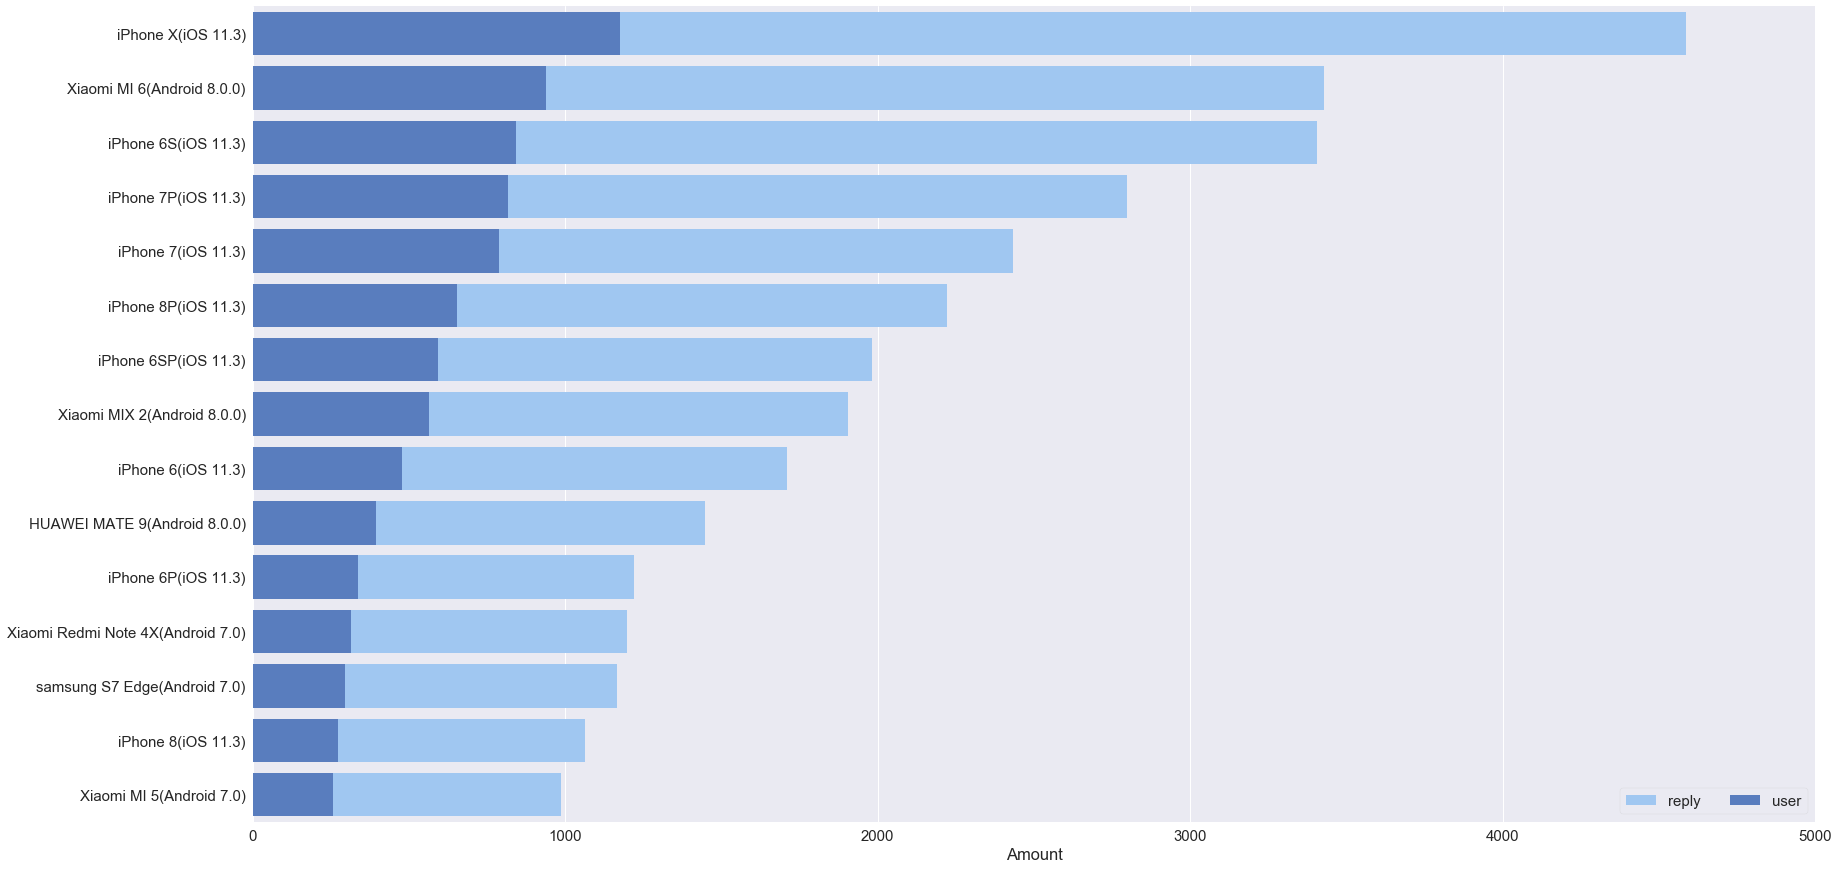

In [266]:
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid")
sns.set(font_scale=1.5)
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(28, 15))

# Load the example car crash dataset
#crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="uid", y="device_cleaned", data=df.groupby('device_cleaned').agg({'uid':'count'}).reset_index().sort_values(by='uid',ascending=False)[:15],
            label=u"reply", color="b")
sns.set_color_codes("muted")
sns.barplot(x="uid", y="device_cleaned", data=df_device.groupby('device_cleaned').agg({'uid':'count'}).reset_index().sort_values(by='uid',ascending=False)[:15],
            label=u"user", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 5000), ylabel="",
       xlabel=u"Amount")
sns.despine(left=True, bottom=True)
plt.savefig("pie_device_uid.png", dpi=200)

In [ ]:
pie_chart(df_device[~df_device.brand.isnull()], 'brand')

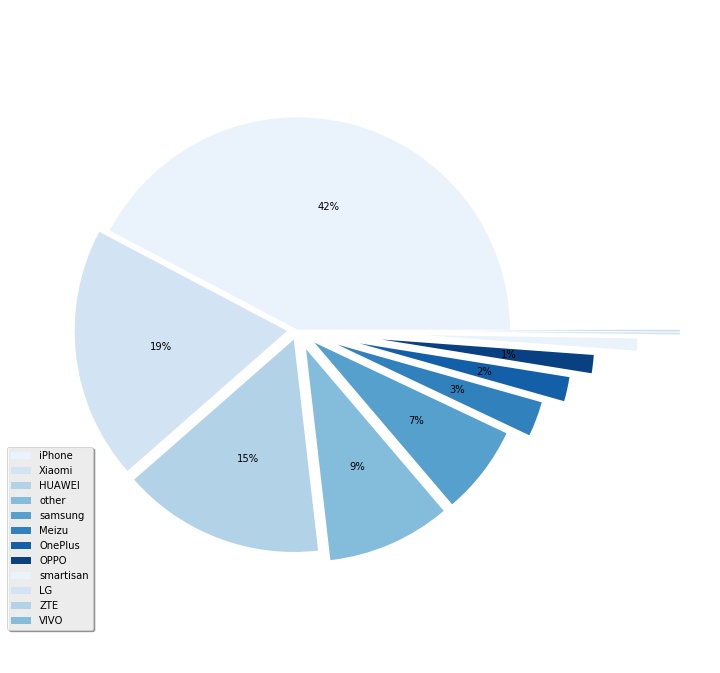

In [138]:
pie_chart(df[df.brand != 'NA'], 'brand')

# Wordcloud

In [305]:
stopwords = pd.read_csv(
"C:/Users/Leslie/Documents/Python Scripts/NGA_AC/stopword.txt", 
encoding='utf8', 
index_col=False,
quoting=3,
sep="\t"
)

In [306]:
segments = []
for w in df.content_cleaned.tolist():
    segs = jieba.cut(w)
    for seg in segs:
        if len(seg)>1:
            segments.append(seg);

In [307]:
segmentDF = pd.DataFrame({'segment':segments})
segmentDF = segmentDF[~segmentDF.segment.isin(stopwords[u'﻿stopword'])]
segStat = segmentDF.groupby(
by=["segment"]
)["segment"].agg({
"计数":np.size
}).reset_index().sort(
columns=["计数"],
ascending=False
);


C:\Users\Leslie\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


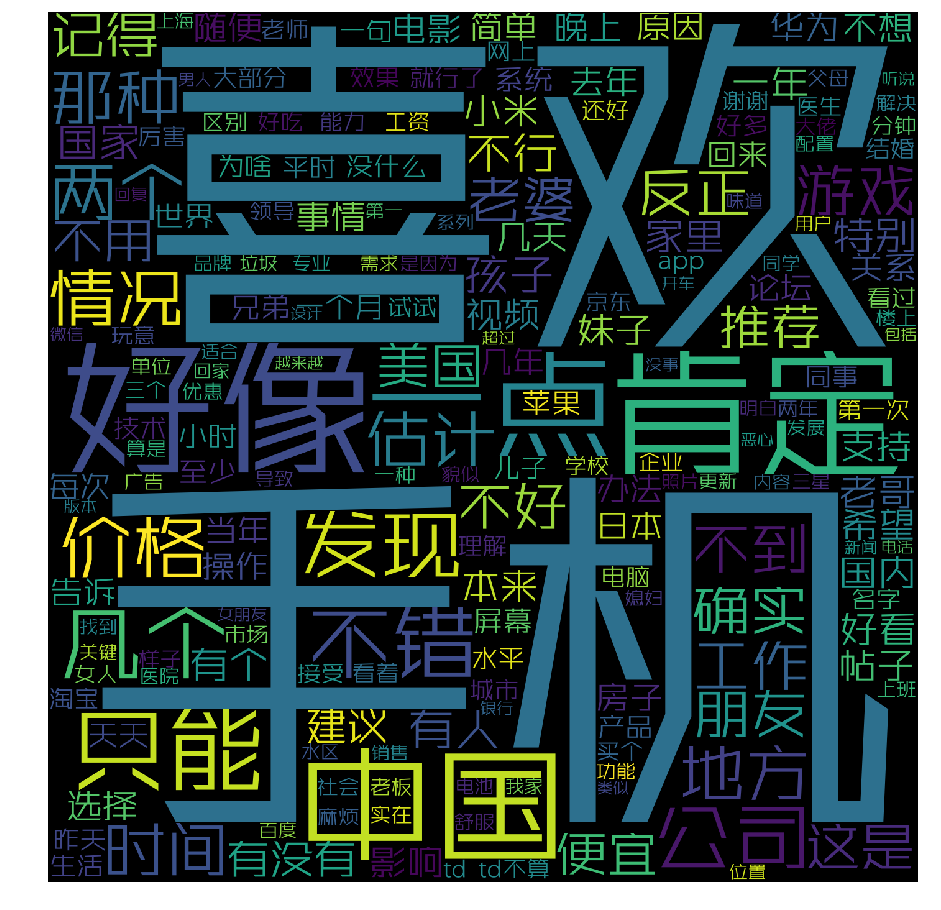

In [308]:
font = r'cu.ttf'
wordcloud = WordCloud(font_path=font,width=1400, height=1400, margin=2,prefer_horizontal=1).generate(' '.join(segmentDF.segment.tolist()))

# width,height,margin可以设置图片属性

# generate 可以对全部文本进行自动分词,但是他对中文支持不好,对中文的分词处理请看我的下一篇文章
#wordcloud = WordCloud(font_path = r'D:\Fonts\simkai.ttf').generate(f)
# 你可以通过font_path参数来设置字体集

#background_color参数为设置背景颜色,默认颜色为黑色

import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("filename.png", dpi=500)
plt.show()
